## What is a Deep Reinforcement Learning trading bot, and does it have soil in our country

### Abstract

Algoritmic trading is a very broad field, that consists of many different methods to create and use computer programs, that usually follow well defined sets of instructions (algorithms) to place a trade. The defined sets of instrucitons are based on timing, price, quantity, or any mathematical model. Some of the benefits of algoritmic trading are that trades are executed fast, at the best possible prices and have reduced transaction costs while also avoiding the risk of manual errors and the effect of any emotional bias that human traders might have while executing a trade.

Arguably the most promissing way to approach the problem of automating trading and decision making in quantitative finance is Deep Reinforcement Learning. Given the fact that trading and investing is an iterative process of trial, error, testing new ideas, receiving feedback from the market in the form of profit/loss, and optimizing the strategy over time, Deep Reinforcement Learning likely has a huge potential of solving these tasks.

The downside is that these type of bots require a lot of data and many iterations(episodes), in order to learn the best policy(optimal trading strategy). Unfortunately this process is painfully slow, and for that reason I will use only a very small portion of the TESLA`s historical stock price data for the purpose of this case study. My personal goal is to try to learn and understand a little bit more about how Reinforcement Learning works, while examining the very interesting context of stock trading.

### Introduction to RL in the context of stock trading

The main Reinforcement Learning components are:
* <b>Agent</b> - An artificial entity that performs actions in an environement. In our case, the Agent will try to be a profitable stock trader. He makes his decisions based on the current market state and his account value.

* <b>Environment</b> - The world where the Agent operates, in this case this would be a simulation of the stock market. Here we dont observe the complete state of the environment and we are not aware of the other traders, whose actions can often influence the movement in the price of a stock in the real world.

* <b>Actions</b> - The things that the Agent can do within the environment. In the context of trading stocks, our agent will have 3 possible actions:hold, buy and sell.

* <b>State</b> - This is the current situation that the Agent is in, in that case the state represents the current market value.

* <b>Reward</b> - The reward function in this case will be the realized Profit and Loss. Holding doesnt bring any reward, while the difference between the sell and buy values tell the Agent if his actions were correct.

* <b>Policy</b> - A policy is an algorithm or a set of rules that describe how an agent makes its decisions. More formally, a policy is a function, that maps a state into an action. at = π(st)

* <b>Value function and Q-value</b> - The value function(or state value) measures the attractiveness of a state through a prediction of future reward. The Q-value refers to e state-action pair(s,a). So, the value function is the expected return for a state, following a policy π, while the Q-value is the expected reward for the state-action pair, following a policy π.

* <b>Model</b> - Reinforcement Learning models often leverage different kinds of neural networks to approximate a value or a policy function. That basically means that, neural networks can learn to map states to values, or state-action pairs to Q-values.

In [1]:
#importing libraries used for loading, processing, visualizing the data and doing the model that outputs the Q-values
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import math
from numpy.random import choice
import random
from collections import deque
from IPython.core.debugger import set_trace
from collections import namedtuple, deque
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

In [2]:
data = pd.read_csv('TSLA2.csv')#loading 

In [3]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-01-04,719.460022,744.489990,717.190002,729.770020,729.770020,48638200
1,2021-01-05,723.659973,740.840027,719.200012,735.109985,735.109985,32245200
2,2021-01-06,758.489990,774.000000,749.099976,755.979980,755.979980,44700000
3,2021-01-07,777.630005,816.989990,775.200012,816.039978,816.039978,51498900
4,2021-01-08,856.000000,884.489990,838.390015,880.020020,880.020020,75055500


In [4]:
data.shape

(282, 7)

In [5]:
data.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [6]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,282.0,8.013908e+02,1.669971e+02,5.525500e+02,6.774775e+02,7.428350e+02,9.076600e+02,1.234410e+03
High,282.0,8.184143e+02,1.725061e+02,5.662100e+02,6.896625e+02,7.556650e+02,9.349200e+02,1.243490e+03
Low,282.0,7.825101e+02,1.604393e+02,5.394900e+02,6.607050e+02,7.319400e+02,8.848825e+02,1.217000e+03
Close,282.0,8.007624e+02,1.665590e+02,5.630000e+02,6.734975e+02,7.435600e+02,9.069200e+02,1.229910e+03
Adj Close,282.0,8.007624e+02,1.665590e+02,5.630000e+02,6.734975e+02,7.435600e+02,9.069200e+02,1.229910e+03
Volume,282.0,2.752927e+07,1.176665e+07,9.800600e+06,1.954895e+07,2.516490e+07,3.273415e+07,8.939650e+07


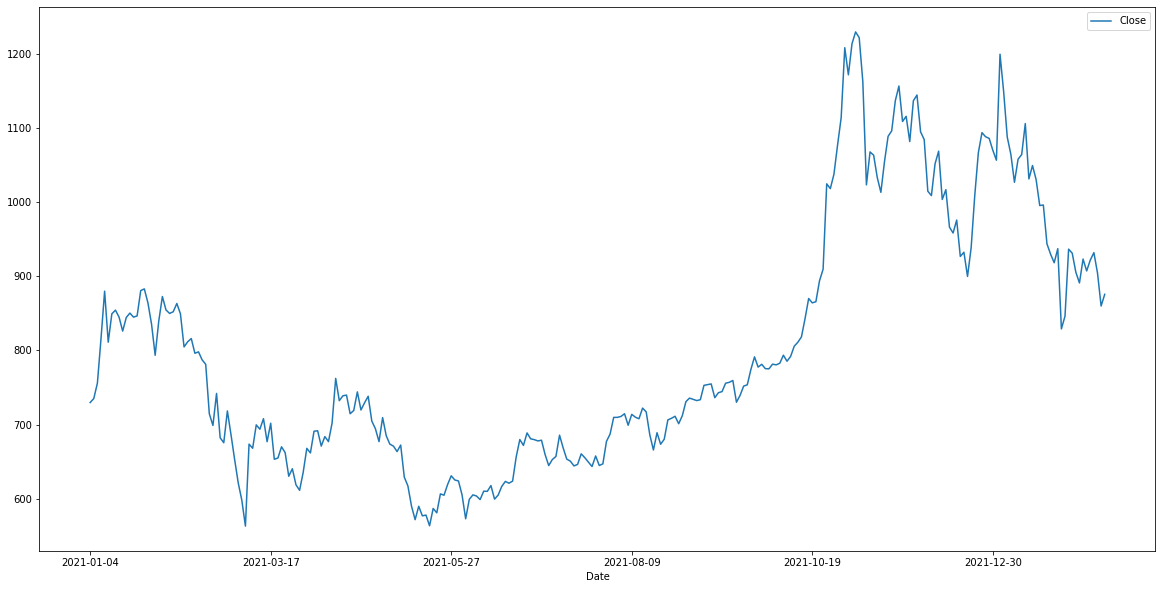

In [7]:
data.set_index('Date')[['Close']].plot(figsize=(20,10))#visualization

In [8]:
#train-test split 80% train/20%test. Using only the Closing price of each day for one year period, because I cant train the agent on more data.
X=list(data["Close"])#list of all closing prices
X=[float(x) for x in X]#list comprehension
validation_size = 0.2#validation size 20% of all data
train_size = int(len(X) * (1-validation_size))#train size 80% of the data
X_train, X_test = X[0:train_size], X[train_size:len(X)]

In this case study we use a Q-Learning approach with Deep Q-Network(DQN). The goal of the model is to come up with a policy and an implementation of a trading strategy. The algorithm takes an action (hold/buy/sell) depending on the current state of the stock price.

The difficulty of building Reinforcement Learning models comes from the class-based code structure and the simultaneous use of several or many modules and functions.

In the first code block we define the Agent class, which holds the variables and functions that perform the Q-Learning. The agent has state size, action size, memory and inventory. The self.gamma parameter refers to prioritizing short-term over long-term profit. The self.epsilon and the following parameters related to it refer to the epsilon greedy approach that we will use here. The idea is to let the Agent take random actions at the beging with the purpose of exploring the environment as quick as possible. While the epsilon parameter dacays, the Agent starts taking less random actions, and is using the models output more while deciding on his action. The model is a neural network that outputs a probability distribution of the action space. Next is the action function that works as follows, if the training is still going, and a randomly generated number is less then or equal to epsilon, the Agent makes a random action, if not then the Agent takes the maximum value from the models output. The experience replay is the key function where, where the neural network is trained based on the observed experience. This function stores a history of state, action, reward and next state transitions that are experienced by the agent. It takes a mini batch of observations (replay memory) as an input and updates the weights of the neural network by minimizing the loss function. The idea of the epsilon greedy approach in this function is to prevent overfitting.


In [9]:
#defining the Agent class
class Agent:
    def __init__(self, state_size, is_eval=False, model_name=""):
        #State size depends and is equal to the the window size, n previous days
        self.state_size = state_size # normalized previous days, 
        self.action_size = 3 # sit, buy, sell / the length of the action space is 3, because there are 3 actions
        self.memory = deque(maxlen=1000)
        self.inventory = []#inventory list
        self.model_name = model_name
        self.is_eval = is_eval

        self.gamma = 0.95#gamma parameter
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995                        
        self.model = load_model(model_name) if is_eval else self._model()

    #Deep Q Learning model- returns the q-value when given state as input 
    def _model(self):
        model = Sequential()
        #Input Layer
        model.add(Dense(units=16, input_dim=self.state_size, activation="relu"))
        #Hidden Layers
        model.add(Dense(units=16, activation="relu"))
        model.add(Dense(units=8, activation="relu"))
        #Output Layer 
        model.add(Dense(self.action_size, activation="linear"))
        model.compile(loss="mse", optimizer=Adam(learning_rate = 0.001))
        return model       
 
    def act(self, state):                 
        if not self.is_eval and random.random() <= self.epsilon:
            return random.randrange(self.action_size)        
        options = self.model.predict(state)        
        #action is based on the action that has the highest value from the q-value function.
        return np.argmax(options[0])

    def expReplay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        for i in range(l - batch_size + 1, l):
            mini_batch.append(self.memory[i])
        
        # the memory during the training phase. 
        for state, action, reward, next_state, done in mini_batch:
            target = reward # reward or Q at time t    
            
            if not done:                
                #max of the array of the predicted. 
                target = reward + self.gamma * np.amax(self.model.predict(next_state)[0])                     
            # Q-value of the state currently from the table    
            target_f = self.model.predict(state)
            # Update the output Q table for the given action in the table     
            target_f[0][action] = target
            #train and fit the model where state is X and target_f is Y, where the target is updated. 
            self.model.fit(state, target_f, epochs=1, verbose=0)
        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

Next we define some helper functions. The format price function is formatting the stock price to two decimal places. The sigmoid function serves as a normalizer. Get state generates the states given the stok data, time t(the day of the prediction) and window n(number of days to look back in time). First, the vector of price difference is computed, followed by scaling this vector from zero to one, using the sigmoid function. This is then returned as the state. The plot behavior function returns the plot of the market price along with indicators for buy and sell actions. It is used for overall evaluation of the algorithm during training and testing.

In [10]:
def formatPrice(n):
    return ("-$" if n < 0 else "$") + "{0:.2f}".format(abs(n))

In [11]:
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

In [12]:
def getState(data, t, n):
 d = t - n + 1
 block = data[d:t + 1] if d >= 0 else -d * [data[0]] + data[0:t + 1]
 res = []
 for i in range(n - 1):
  res.append(sigmoid(block[i + 1] - block[i]))
 return np.array([res])

In [13]:
def plot_behavior(data_input, states_buy, states_sell, profit):
    fig = plt.figure(figsize = (15,5))
    plt.plot(data_input, color='r', lw=2.)
    plt.plot(data_input, '^', markersize=10, color='m', label = 'Buying signal', markevery = states_buy)
    plt.plot(data_input, 'v', markersize=10, color='k', label = 'Selling signal', markevery = states_sell)
    plt.title('Total gains: %f'%(profit))
    plt.legend()
    #plt.savefig('output/'+name+'.png')
    plt.show()

### Training the model

To train the model, we define the following variables and instantiate the stock agent. Episode is the number of passes through the whole training set. Window size is the number of days to consider to evaluate the state. Batch size refers to the size of the replay buffer or memory during training. The steps of the training are :

* Get the current state using the getState function. It returns a vector of states, where the length of the vector is defined by the window_size, and the values of the state are normalized between 0 and 1.

* Get the action of the current state using the act function of the Agent class.

* Get the reward of the given action. As discussed before, the reward is defined as the difference between the sell and buy values, the hold action doesnt bring any reward.

* Get the next state using the function.

* The details of each action, state and reward is saved in the Agents memory, which is further used by the experience replay function.

* Check if the memory is bigger then the defined batch size. If yes, then we continue to the experience replay function and update the Q function by minimizing the MSE between the Q-predicted and the Q-target. If not, then we move to the next step.

Running episode 0/10
--------------------------------
Total Profit: -$744.02
--------------------------------


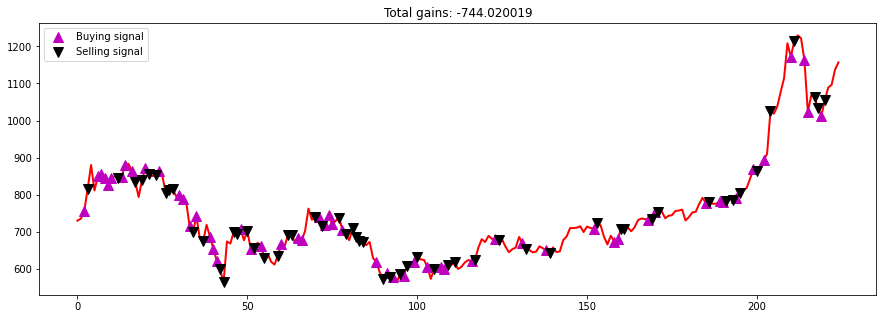

INFO:tensorflow:Assets written to: model_ep0/assets
Running episode 1/10
--------------------------------
Total Profit: $150.44
--------------------------------


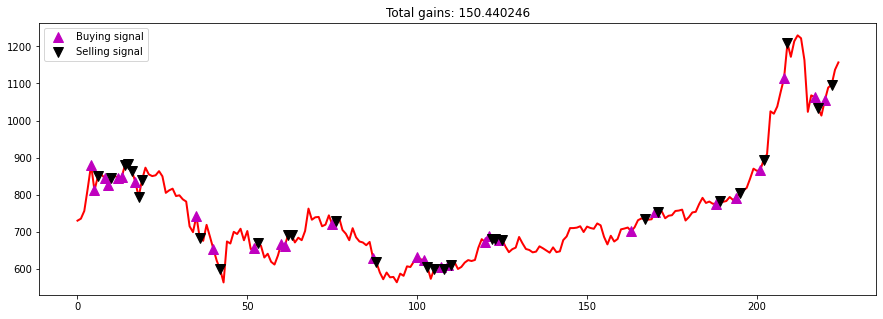

Running episode 2/10
--------------------------------
Total Profit: $5539.26
--------------------------------


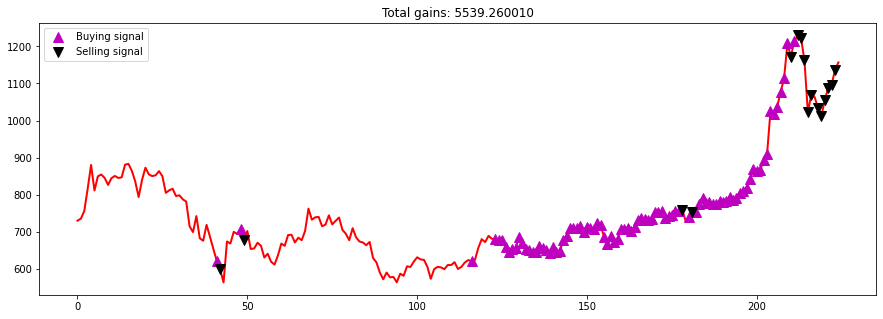

INFO:tensorflow:Assets written to: model_ep2/assets
Running episode 3/10
--------------------------------
Total Profit: $348.05
--------------------------------


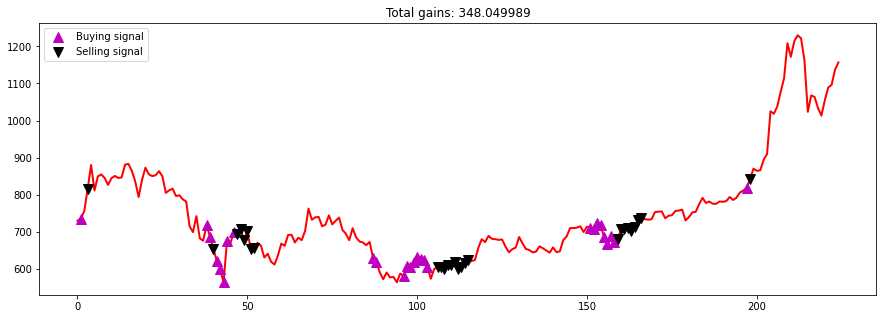

Running episode 4/10
--------------------------------
Total Profit: $556.60
--------------------------------


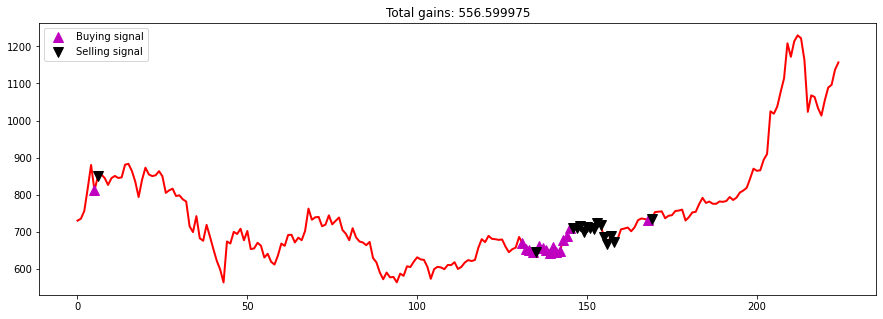

INFO:tensorflow:Assets written to: model_ep4/assets
Running episode 5/10
--------------------------------
Total Profit: -$120.83
--------------------------------


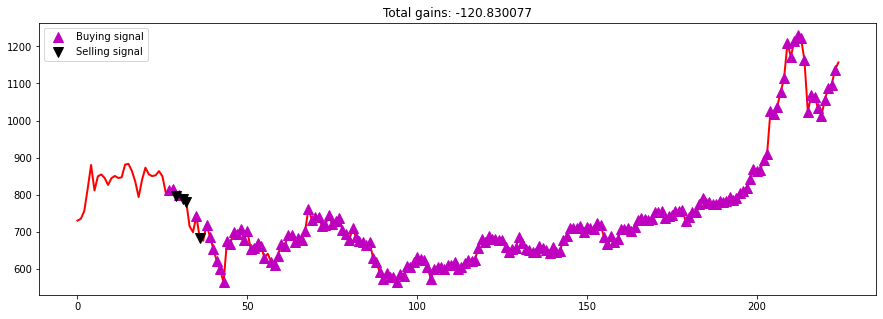

Running episode 6/10
--------------------------------
Total Profit: -$52.87
--------------------------------


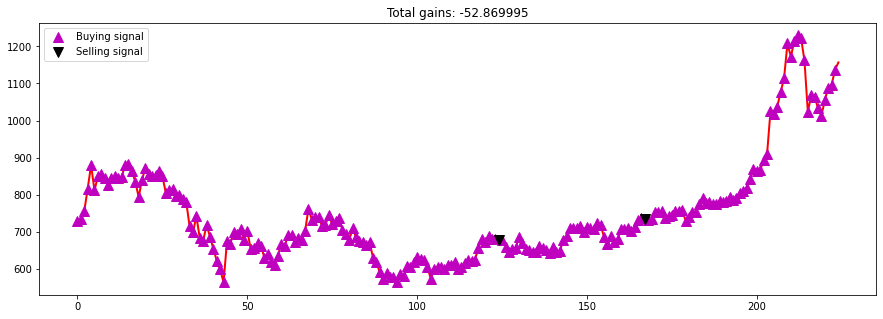

INFO:tensorflow:Assets written to: model_ep6/assets
Running episode 7/10
--------------------------------
Total Profit: $0.00
--------------------------------


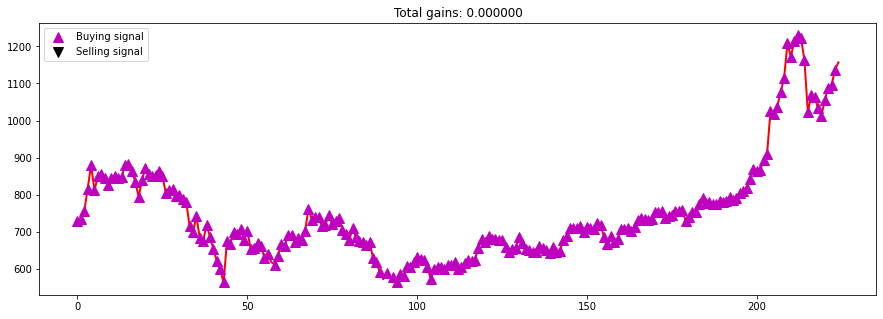

Running episode 8/10
--------------------------------
Total Profit: $0.00
--------------------------------


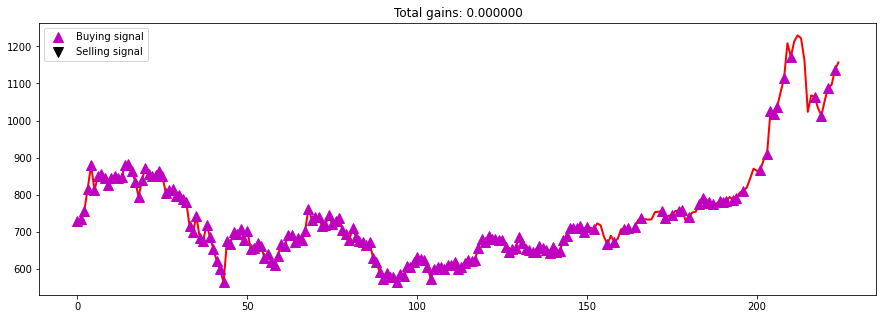

INFO:tensorflow:Assets written to: model_ep8/assets
Running episode 9/10
--------------------------------
Total Profit: $100.19
--------------------------------


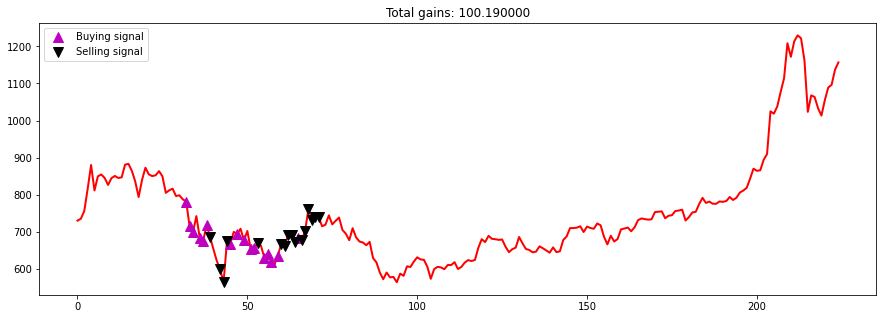

Running episode 10/10
--------------------------------
Total Profit: $38.15
--------------------------------


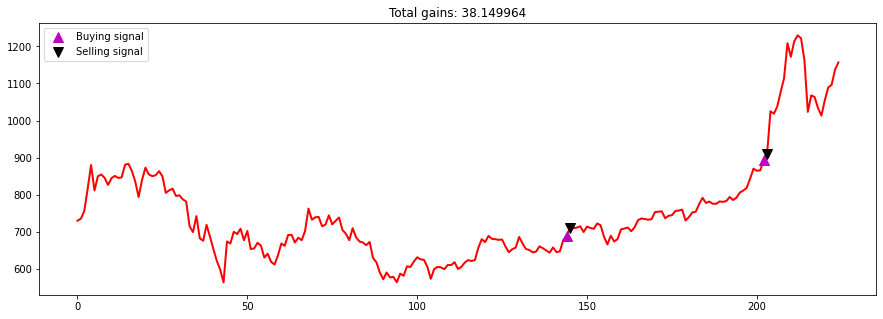

INFO:tensorflow:Assets written to: model_ep10/assets


In [14]:
window_size = 1
agent = Agent(window_size)
#In this step we feed the closing value of the stock price 
data = X_train
l = len(data) - 1
#
batch_size = 32
#An episode represents a complete pass over the data.
episode_count = 10

for e in range(episode_count + 1):
    print("Running episode " + str(e) + "/" + str(episode_count))
    state = getState(data, 0, window_size + 1)    
    total_profit = 0
    agent.inventory = []
    states_sell = []
    states_buy = []
    for t in range(l):
        action = agent.act(state)    
        # sit
        next_state = getState(data, t + 1, window_size + 1)
        reward = 0

        if action == 1: # buy
            agent.inventory.append(data[t])
            states_buy.append(t)            

        elif action == 2 and len(agent.inventory) > 0: # sell
            bought_price = agent.inventory.pop(0)      
            reward = max(data[t] - bought_price, 0)
            total_profit += data[t] - bought_price
            states_sell.append(t)            

        done = True if t == l - 1 else False
        #appends the details of the state action etc in the memory, which is used further by the exeReply function
        agent.memory.append((state, action, reward, next_state, done))
        state = next_state

        if done:
            print("--------------------------------")
            print("Total Profit: " + formatPrice(total_profit))
            print("--------------------------------")
            
            plot_behavior(data,states_buy, states_sell, total_profit)
        if len(agent.memory) > batch_size:
            agent.expReplay(batch_size)    
            

    if e % 2 == 0:
        agent.model.save("model_ep" + str(e))

### Testing the model

In [15]:
test_data = X_test
l_test = len(test_data) - 1
state = getState(test_data, 0, window_size + 1)
total_profit = 0
is_eval = True
done = False
states_sell_test = []
states_buy_test = []
model_name = "model_ep"+str(episode_count)
agent = Agent(window_size, is_eval, model_name)
state = getState(data, 0, window_size + 1)
total_profit = 0
agent.inventory = []

------------------------------------------
Total Profit: $0.00
------------------------------------------


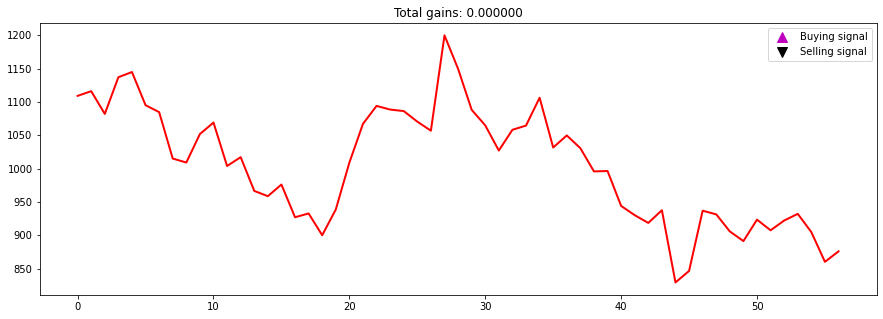

In [16]:
for t in range(l_test):
    action = agent.act(state)
    #print(action)
    #set_trace()
    next_state = getState(test_data, t + 1, window_size + 1)
    reward = 0

    if action == 1:
        agent.inventory.append(test_data[t])
        states_buy_test.append(t)
        

    elif action == 2 and len(agent.inventory) > 0:
        bought_price = agent.inventory.pop(0)
        reward = max(test_data[t] - bought_price, 0)
        #reward = test_data[t] - bought_price
        total_profit += test_data[t] - bought_price
        states_sell_test.append(t)
        

    if t == l_test - 1:
        done = True
    agent.memory.append((state, action, reward, next_state, done))
    state = next_state

    if done:
        print("------------------------------------------")
        print("Total Profit: " + formatPrice(total_profit))
        print("------------------------------------------")
        
plot_behavior(test_data,states_buy_test, states_sell_test, total_profit)

### Conclusion

The agent is clearly not doing well. It is not finding a good strategy on the train set, and is refusing to do anything on the test one. For sure there is a  big need of longer training, more data, and model improving.

### References

https://www.mlq.ai/deep-reinforcement-learning-trading-strategies-automl/

https://www.mlq.ai/guide-to-deep-reinforcement-learning/

https://www.mlq.ai/deep-reinforcement-learning-for-trading-with-tensorflow-2-0/

https://www.mlq.ai/deep-reinforcement-learning-q-learning/

https://www.oreilly.com/library/view/machine-learning-and/9781492073048/